### Image Classification with Pretrained ResNet-18 in PyTorch

# Objectives

Develop an image classification model using a pretrained ResNet-18 network.

Apply data augmentation techniques to improve model generalization.

Fine-tune the model on a custom dataset for accurate predictions.

Evaluate model performance using training and validation accuracy.

Provide a reusable pipeline for training and testing image classification tasks.

# Importing required libraries

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Data Transformations

#### Training images :
resized to 224×224, randomly flipped and rotated, converted to tensors, and normalized.

#### Validation images: 
resized, converted to tensors, and normalized (no augmentation).

In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

##### Dataset : mages are loaded from dataset/train and dataset/validation using ImageFolder.
 
##### Transformations: training and validation transforms are applied.

##### DataLoader:  batches of 32 images are created; training data is shuffled, validation data is not.

##### Classes:  class_names stores all class labels in the datase

In [8]:
train_dataset = datasets.ImageFolder("dataset/train", transform=train_transforms)
val_dataset = datasets.ImageFolder("dataset/validation", transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,drop_last=False)
    
class_names = train_dataset.classes
print(class_names)


['fresh_apple', 'fresh_banana', 'fresh_strewberry', 'rotten_apple', 'rotten_banana', 'rotten_strewberry']


#### Batch & Classes

Loads one batch of training images and labels.

Counts the total number of classes in the dataset.

In [9]:
images, labels = next(iter(train_loader))
num_classes = len(train_dataset.classes)

### Device Setup

Checks if a GPU (CUDA) is available; if not, uses the CPU.

Ensures the model and data run on the best available device for faster training.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model Setup

Loads a pretrained ResNet-18 model.

Freezes all existing layers so only the final layer will be trained.

Replaces the fully connected (fc) layer to match the number of classes in the dataset.

Moves the model to the selected device (GPU or CPU).

In [11]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

c:\Users\beach\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\beach\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Loss Function & Optimizer

Loss: CrossEntropyLoss for multi-class classification.

Optimizer: Adam updates only the final layer (fc) with a learning rate of 0.0001.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

## Training Model

Trains the model for 15 epochs.

For each batch:

Moves images and labels to the device (GPU/CPU).

Computes predictions and loss.

Backpropagates the loss and updates the final layer weights.

Tracks running loss and training accuracy for each epoch.

Prints loss and accuracy after every epoch.

In [13]:
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_acc = correct / len(train_dataset)
    print(f"Epoch {epoch+1} | Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f}")


Epoch 1 | Loss: 28.0572 | Train Acc: 0.1062
Epoch 2 | Loss: 24.5802 | Train Acc: 0.3079
Epoch 3 | Loss: 22.4919 | Train Acc: 0.4246
Epoch 4 | Loss: 20.9423 | Train Acc: 0.5159
Epoch 5 | Loss: 19.2388 | Train Acc: 0.5881
Epoch 6 | Loss: 17.7445 | Train Acc: 0.6497
Epoch 7 | Loss: 16.5195 | Train Acc: 0.6858
Epoch 8 | Loss: 15.5918 | Train Acc: 0.7134
Epoch 9 | Loss: 14.5669 | Train Acc: 0.7346
Epoch 10 | Loss: 13.9823 | Train Acc: 0.7601
Epoch 11 | Loss: 13.0686 | Train Acc: 0.7707
Epoch 12 | Loss: 12.1502 | Train Acc: 0.7898
Epoch 13 | Loss: 11.4408 | Train Acc: 0.8217
Epoch 14 | Loss: 10.8111 | Train Acc: 0.8280
Epoch 15 | Loss: 10.3090 | Train Acc: 0.8365


## Model Evaluation

Switches the model to evaluation mode (model.eval()).

Disables gradient computation with torch.no_grad() for faster inference.

For each batch in the validation set:

Moves images and labels to the device.

Computes predictions and loss.

Counts correct predictions.

Calculates and prints the overall validation accuracy.

Validation Acc: 0.7812
Classification Report:
                    precision    recall  f1-score   support

      fresh_apple       1.00      0.88      0.93        24
     fresh_banana       1.00      0.38      0.55         8
 fresh_strewberry       0.61      0.96      0.75        26
     rotten_apple       1.00      0.73      0.85        15
    rotten_banana       0.74      0.93      0.82        15
rotten_strewberry       1.00      0.12      0.22         8

         accuracy                           0.78        96
        macro avg       0.89      0.67      0.69        96
     weighted avg       0.85      0.78      0.76        96



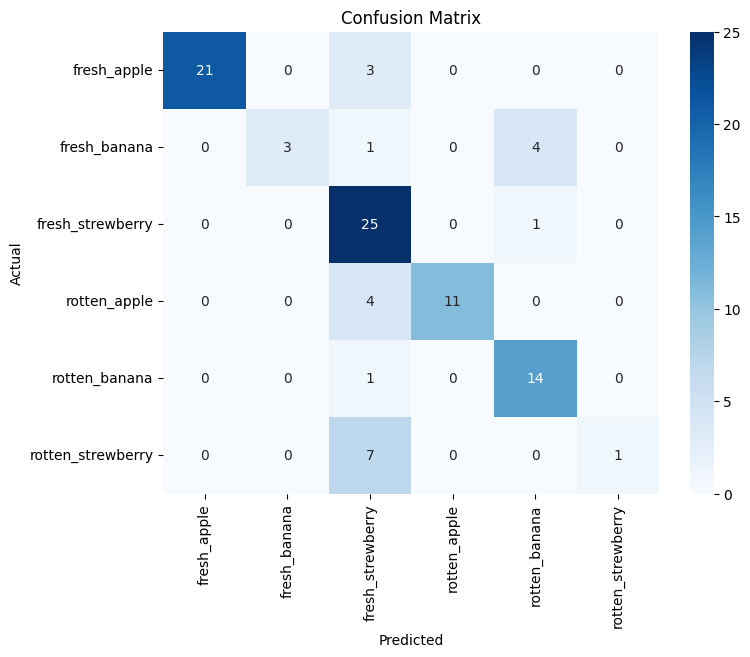

In [14]:
model.eval()
val_correct = 0
val_loss = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        val_correct += (preds == labels).sum().item()

val_acc = val_correct / len(val_dataset)
print(f"Validation Acc: {val_acc:.4f}")

all_preds = []
all_labels = []

# جمع کردن پیش‌بینی‌ها و برچسب‌ها
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)
# محاسبه ماتریس درهم‌ریختگی (Confusion Matrix)
cm = confusion_matrix(all_labels, all_preds)

# نمایش بصری با heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()